In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls '/content/drive/MyDrive/Nurul&Nabil(thesis)/Ner_dataset'

 annotated_dataset_2.csv    atis_intents.csv	  flagged
'atis_intents (1).gsheet'   atis_intents.gsheet


In [ ]:
import os
os.chdir("/content/drive/My Drive/Nurul&Nabil(thesis)/Ner_dataset")

In [ ]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data={"intents":[{
		"tag": "atis_flight",
		"responses": ["Yes,flight is available","No,flight isn't available","Departure: 23:00  -  Arrival:  8:30","Departure : 1:40","Arrival: 5:30"]
	},{
		"tag": "atis_flight_time",
		"responses": [" Departure: 8:00  -  Arrival: 20:00","Departure: 10:00","Arrival: 16:00"]
	},{
		"tag": "atis_airfare",
		"responses": [ " 560$ ", "690$", "710$", "1200$"]
	},{
		"tag": "atis_airport",
		"responses": ["Hartsfield–Jackson Atlanta International Airport","Dallas/Fort Worth International Airport","Denver International Airport","Los Angeles International Airport"]
	},{
		"tag": "atis_ground_service",
		"responses": ["Airport Limousine Service Sedan (4 passenger) - $45 and up, SUV (6 passenger) - $53 and up, Stretch Limousine (6 passenger) - $55 and up, (702) 888-4848 or (888) 696-4400"]
	},{
		"tag": "atis_aircraft",
		"responses": ["F/A-18A Hornet","F-35B Lightning II","UC-12W Huron","C-2A Greyhound"," Airbus A380"]
	},{
      "tag":"atis_airline",
      "responses": ["American Airlines","Avelo Airlines","Breeze Airways","Delta Air Lines"]
  },{
      "tag":"atis_abbreviation",
      "responses": ["A - First Class Discounted","B - Economy/Coach – Usually an upgradable fare to Business","C - Business Class","D - Business Class Discounted","E - Shuttle Service (no reservation allowed) or Economy/Coach Discounted",
                     "F - First Class","G - Conditional Reservation","H - Economy/Coach Discounted"]
  },{
      "tag":"atis_flight_no",
      "responses": ["2490","2491","2492"]
  },{
      "tag":"atis_quantity",
     "responses":["4 different classes ","5 classes"]

  },{
      "tag":"atis_city",
      "responses":["Appleton, WI (ATW)","Atlanta, GA (ATL)","Boston, MA (BOS)","Cleveland, OH (CLE)","Columbus, OH (CMH)","Dallas/Fort Worth, TX (DFW)","Denver, CO (DEN)"]
  },{
      "tag":"atis_capacity",
     "responses":["100 passengers","200 passengers","50 passengers","500 passengers","1000 passengers"]
  },{
      "tag":"atis_distance",
      "responses":["13 min (12.2 mi) via US-101 S","8 min (2.6 mi) via Las Vegas Blvd S and E Tropicana Ave"]
  },{
      "tag":"atis_ground_fare",
     "responses":["Full-size SUV : $30/day", "Mini :	$50/day","Premium  :	$27/day","Passenger van	$89/day"]
  },{
      "tag":"atis_airport",
     "responses":["airports in New York","Birmingham","Huntsville","Dothan"]
  },{
      "tag":"atis_meal",
     "responses":["yes,a meal is available","No,there is no meal available"]
  },{
      "tag":"atis_restriction",
      "responses":["some restriction"]
  },{
      "tag":"atis_cheapest",
     "responses":["200$-300$"]
  }
]}

In [ ]:
df=pd.read_csv("atis_intents.csv")
df

,atis_flight,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...
...,...,...
4972,atis_airfare,what is the airfare for flights from denver t...
4973,atis_flight,do you have any flights from denver to baltim...
4974,atis_airline,which airlines fly into and out of denver
4975,atis_flight,does continental fly from boston to san franc...


In [ ]:
df.columns=['label','text']
df

,label,text
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...
...,...,...
4972,atis_airfare,what is the airfare for flights from denver t...
4973,atis_flight,do you have any flights from denver to baltim...
4974,atis_airline,which airlines fly into and out of denver
4975,atis_flight,does continental fly from boston to san franc...


In [ ]:
df['label'].value_counts()

atis_flight                                 3665
atis_airfare                                 423
atis_ground_service                          255
atis_airline                                 157
atis_abbreviation                            147
atis_aircraft                                 81
atis_flight_time                              54
atis_quantity                                 51
atis_flight#atis_airfare                      21
atis_airport                                  20
atis_distance                                 20
atis_city                                     19
atis_ground_fare                              18
atis_capacity                                 16
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               6
atis_airline#atis_flight_no                    2
atis_ground_service#atis_ground_fare           1
atis_airfare#atis_flight_time                  1
atis_cheapest       

In [ ]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# check class distribution
df['label'].value_counts(normalize = True)

12    0.736387
3     0.084991
17    0.051236
5     0.031545
0     0.029536
1     0.016275
15    0.010850
20    0.010247
13    0.004219
7     0.004018
11    0.004018
10    0.003818
16    0.003617
8     0.003215
14    0.002411
19    0.001206
21    0.001206
6     0.000402
18    0.000201
4     0.000201
9     0.000201
2     0.000201
Name: label, dtype: float64

In [ ]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df['text'], df['label']

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer('text', padding=True,truncation=True, return_tensors='pt')
print(encoded_input)
'''In input_ids:
101 - Indicates beginning of the sentence
102 - Indicates end of the sentence
In attention_mask:
1 - Actual token
0 - Padded token'''

{'input_ids': tensor([[ 101, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1]])}


'In input_ids:\n101 - Indicates beginning of the sentence\n102 - Indicates end of the sentence\nIn attention_mask:\n1 - Actual token\n0 - Padded token'

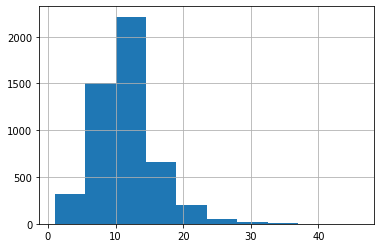

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 16
max_seq_len = 16

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print(len(train_mask))

4977


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 64
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
print(len(train_dataloader))
print(train_data)

78


In [ ]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.1)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,3072)
       self.fc2 = nn.Linear(3072,768)
       self.fc3 = nn.Linear(768,22)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           2,362,368
├─Linear: 1-5                                           2,360,064
├─Linear: 1-6                                           16,918
├─LogSoftmax: 1-7                                       --
T

In [ ]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight(class_weight='balanced',classes= np.unique(train_labels),y= train_labels)
print(len(class_wts))

22


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [ ]:
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 2
# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [ ]:
# function to train the model
def train():
  
  model.train()
  tot_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 1000 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    print(preds)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
   
    # add on to the total loss
    tot_loss = tot_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = tot_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds
  


In [ ]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 2
tensor([[-3.0760, -3.1656, -3.0583,  ..., -3.1207, -3.0178, -3.0575],
        [-3.0498, -3.1370, -3.0683,  ..., -3.1113, -3.0552, -3.0945],
        [-3.0664, -3.1011, -3.0550,  ..., -3.0855, -3.0509, -3.0917],
        ...,
        [-3.0755, -3.1656, -3.0822,  ..., -3.0518, -3.0221, -3.1181],
        [-3.0478, -3.1837, -3.0783,  ..., -3.1489, -3.0038, -3.1343],
        [-3.0238, -3.1207, -3.0616,  ..., -3.1335, -3.0231, -3.1150]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.5165, -2.7828, -3.2488,  ..., -3.4280, -2.4914, -3.4314],
        [-2.5379, -2.8524, -3.3149,  ..., -3.5444, -2.5458, -3.4276],
        [-2.5123, -2.7980, -3.2593,  ..., -3.4214, -2.5445, -3.4304],
        ...,
        [-2.5170, -2.6257, -3.3905,  ..., -3.5239, -2.4503, -3.4180],
        [-2.5134, -2.8554, -3.3475,  ..., -3.4921, -2.4646, -3.4073],
        [-2.5490, -2.8110, -3.3444,  ..., -3.4494, -2.4647, -3.4321]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([

In [ ]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 print(test_text)
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print('Intent Identified: ', le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
def get_response(message): 
  intent = get_prediction(message)
  for i in data['intents']: 
    
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result
      


In [ ]:
out=get_response(' the name of the denver airport')

[' the name of the denver airport']
Intent Identified:  atis_airport
Response : Dallas/Fort Worth International Airport


In [ ]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr

In [ ]:
demo=gr.Interface(fn=get_response,
             inputs=['text'],
             outputs=['text'])

In [ ]:
demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>